Подключаем библиотеки

In [1107]:
import numpy as np
import pandas as pd
!pip install featuretools
!pip install xgboost
!pip install lightgbm
!pip install catboost

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
from sklearn.metrics import f1_score, precision_score, recall_score, \
                            classification_report, confusion_matrix, accuracy_score, f1_score

Загружаем данные

In [1108]:

train = './data/course_project_train.csv'
test = './data/course_project_test.csv'
description = open('./data/description.txt', "r", encoding="utf-8")

PREP_DATASET_PATH = './data/training_project_data_prep.csv'

train = pd.read_csv(train)
test = pd.read_csv(test)

In [1109]:
print((description.read()))

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)\n

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)

Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)

Monthly Debt - ежемесячный долг

Credit Score - баллы кредитного рейтинга

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


Проводим анализ данных

In [1110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

В датасете присутсвуют пропуски, а также нечисловые признаки

In [1111]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

На обучающей выборке присутсвует диспаланс классов целевой переменной.

In [1112]:
train.describe(percentiles= [0.01,0.1,0.25,0.5,0.75,0.9,0.99])

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
1%,3.282250e+05,0.000000,3.000000,6.500000,1.726978e+04,0.000000,1.000000,0.000000,4.318556e+04,1.443810e+03,1320.950000,626.000000,0.000000
10%,6.220600e+05,0.000000,6.000000,10.400000,1.655720e+05,0.000000,8.000000,0.000000,1.096238e+05,5.751870e+04,5748.900000,684.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
90%,2.276736e+06,0.000000,17.000000,28.000000,1.245904e+06,1.000000,68.000000,1.000000,1.000000e+08,5.970028e+05,32983.000000,749.000000,1.000000


Максимальное значение Annual Income подозиртельно большое.

Признак Tax Liens странный, не совсем понятно что означают его значения, а так же он имеет ненулевые значения только у 1% объектов. Вероятно от него прийдется избавиться либо заменить на булевые признаки Tax Liens = 0 и Tax Liens > 0

Максимальное значение Number of Open Accounts подозиртельно большое. Так же есть сомнения в полезности данного признака.

Максимальное и минимальное значения Maximum Open Credit на порядки отличаются от 99 и 1 перцентилей. 

Признак Number of Credit Problems необходимо изучить подробнее. Он отличен от нуля только у 10% объектов. 

Признак Bankruptcies необходимо изучить подробнее. 

У признака Current Loan Amount имеется большой скачек значений между 75 и 90 перцентилем, так же наибольшие 10% объектов имеют одинаковое значение. Стоит посмотреть график распределения значений данного параметра. 

Значения Credit Score очень сильно возрастают от 90 к 99 перцентилю.

Теперь посмотрим на нечисловые признаки

In [1113]:
train[train.select_dtypes(include='object').columns].head(10)

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,NaN,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term
5,Rent,7 years,other,Long Term
6,Home Mortgage,10+ years,home improvements,Short Term
7,Rent,10+ years,other,Short Term
8,Home Mortgage,5 years,home improvements,Short Term
9,Home Mortgage,1 year,debt consolidation,Long Term


In [1114]:
for o in train.select_dtypes(include='object').columns:
    print(train[o].value_counts(), '\n')

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64 

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64 

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64 

Short Term    5556
Long Term     1944
Name: Term, dtype: int64 



Home Ownership стоит перевести в булевы признаки и возможно стоит объединить Home Mortgage и Have Mortgage так как логически это вроде как одно и тоже и Have Mortgage имеет всего 12 объектов. 

Years in current job возможно стоит переделать в числовой признак, либо тоже в булевые.

У Purpose подавляющее большинство признака имеет значение debt consolidation. Нужно проверить влияние данного признака на целевую переменную и корреляции с другими. Пока не очень понятно нужен ли он вообще.

Term заменим на булевые признаки.

Заполним пропуски в данных и избавимся от потенциальных выбросов.

In [1115]:
def s1(df):
    s2 = df.select_dtypes(include='object').columns
    s3 = df.select_dtypes(exclude='object').columns
    for s5 in s3:
        df[s5] = df[s5].fillna(df[s5].median())
    for s4 in s2:
        df[s4] = df[s4].fillna(df[s4].mode())

    for s6 in s3:
        df.loc[df[s6] < df[s6].quantile(q = 0.01), [s6]] = df[s6].quantile(q = 0.01)
        df.loc[df[s6] > df[s6].quantile(q = 0.99), [s6]] = df[s6].quantile(q = 0.99)
    

In [1116]:
s1(train)
train.describe(percentiles=[0.1,0.5,0.9,0.95])

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.310095e+06,0.017867,11.100667,18.284077,6.348151e+05,0.157333,33.222800,0.110133,1.187331e+07,2.812933e+05,18184.129333,1063.504033,0.281733
std,6.558354e+05,0.132476,4.766154,6.870046,5.659747e+05,0.415134,14.587847,0.313077,3.192607e+07,2.553940e+05,11277.579985,1435.765762,0.449874
min,3.644662e+05,0.000000,3.000000,6.500000,1.726978e+04,0.000000,3.000000,0.000000,4.318556e+04,1.443810e+03,1320.950000,632.990000,0.000000
10%,6.727083e+05,0.000000,6.000000,10.400000,1.655720e+05,0.000000,14.000000,0.000000,1.096238e+05,5.751870e+04,5748.900000,691.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
90%,2.088786e+06,0.000000,17.000000,28.000000,1.245904e+06,1.000000,54.000000,1.000000,1.000000e+08,5.970028e+05,32983.000000,748.000000,1.000000
95%,2.622773e+06,0.000000,20.000000,31.900000,1.706333e+06,1.000000,67.000000,1.000000,1.000000e+08,7.665930e+05,40546.200000,6560.500000,1.000000
max,4.225967e+06,1.000000,27.000000,40.401000,3.568459e+06,2.000000,79.000000,1.000000,1.000000e+08,1.483079e+06,58113.130000,7370.000000,1.000000


In [1117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7130 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Теперь подробнее рассмотрим признаки. Сперва посмотрим на числовые признаки.

In [1118]:
def q1(df,x,y):
    q2 = df[x].value_counts().index
    q3 = []
    q9 = []
    for q6 in q2:
        q7 = df[y].loc[df[x] == q6].mean()
        q8 = df[x].loc[df[x] == q6].count()
        q3.append(q7)
        q9.append(q8)
    u = {x + ' ' + 'values':q2, 'mean ' + y:q3, 'count ' + x:q9}
    u = pd.DataFrame(u)
    u.sort_values(by='mean ' + y, inplace=True)
    print(u)
    
    rcParams["figure.figsize"] = 12, 8
    
    plt.plot(u[u.columns[0]], u[u.columns[1]])
    plt.xlabel(u.columns[0])
    plt.ylabel(u.columns[1])
    
    plt.show

In [1119]:
def q2(df,x,y):
    q3 = []
    q9 = []
    for q6 in np.arange(0, 1, 0.05):
        q0 = q6 + 0.05
        q7 = df[y][df[x].between(df[x].quantile(q = q6), df[x].quantile(q = q0))].mean()
        q8 = df[x][df[x].between(df[x].quantile(q = q6), df[x].quantile(q = q0))].mean()
        q3.append(q7)
        q9.append(q8)
    u = {x + ' ' + 'values':q9, 'mean ' + y:q3}
    u = pd.DataFrame(u)
    u.sort_values(by='mean ' + y, inplace=True)
    
    rcParams["figure.figsize"] = 12, 8
    
    plt.plot(u[u.columns[0]], u[u.columns[1]])
    plt.xlabel(u.columns[0])
    plt.ylabel(u.columns[1])

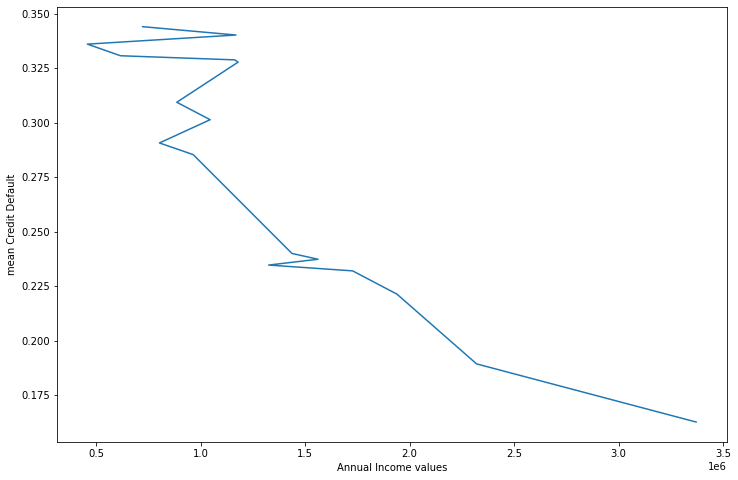

In [1120]:
q2(train, 'Annual Income', 'Credit Default')

Прослеживается относительно четкая тенденция - чем больше Annual Income тем больше тем больше вероятность что объект относиться к 0 классу. 

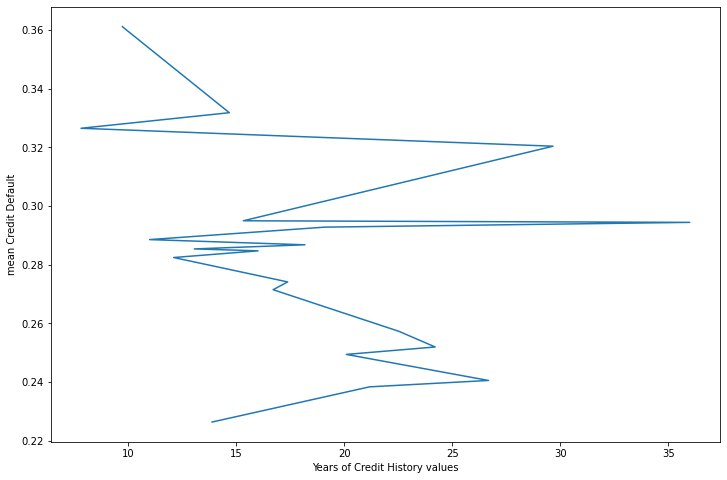

In [1121]:
q2(train, 'Years of Credit History', 'Credit Default')

Не похоже что этот сильно полезен для определения целевой переменной.

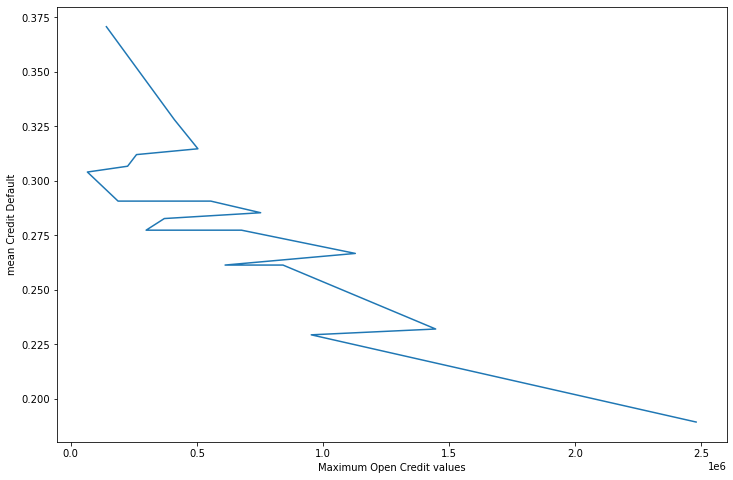

In [1122]:
q2(train, 'Maximum Open Credit', 'Credit Default')

Здесь так же можно разглядеть тенденцию, что при возрастании Maximum Open Credit целевая переменная стремится к нулевому классу.

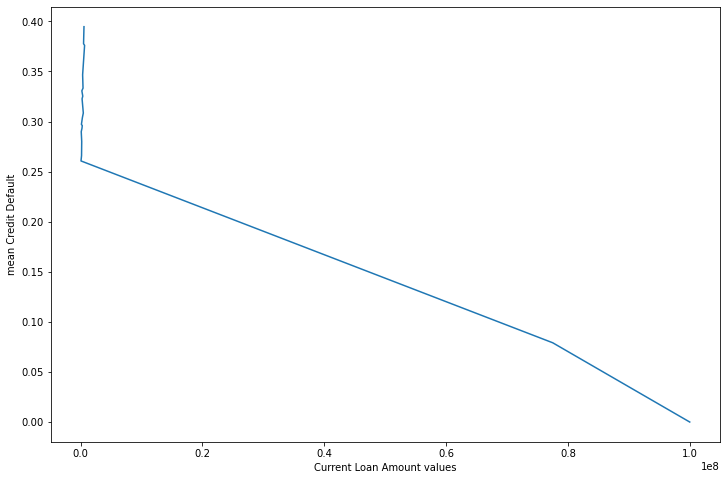

In [1123]:
q2(train, 'Current Loan Amount', 'Credit Default')

Не очень понятно. Исследуем ещё различные срезы по данному параметру. 

In [1124]:
tr1 = train.loc[train['Current Loan Amount'] < 500000]
tr1['Current Loan Amount'].count()

5552

In [1125]:
tr2 = train.loc[train['Current Loan Amount'] < 800000]
print(tr2['Current Loan Amount'].count())
print(max(tr2['Current Loan Amount']))
print(min(tr2['Current Loan Amount']))

6630
789030.0
43185.560000000005


In [1126]:
tr3 = train.loc[train['Current Loan Amount'] < 1000000]
tr3['Current Loan Amount'].count()

6630

In [1127]:
tr4 = train.loc[train['Current Loan Amount'] < 3000000]
tr4['Current Loan Amount'].count()

6630

In [1128]:
tr5 = train.loc[train['Current Loan Amount'] < 10000000]
tr5['Current Loan Amount'].count()

6630

In [1129]:
tr6 = train.loc[train['Current Loan Amount'] > 10000000]
print(min(tr6['Current Loan Amount']))
print(np.mean(tr6['Current Loan Amount']))
print(max(tr6['Current Loan Amount']))
print(tr6['Current Loan Amount'].count())
print(tr6['Credit Default'].mean())

99999999.0
99999999.0
99999999.0
870
0.0


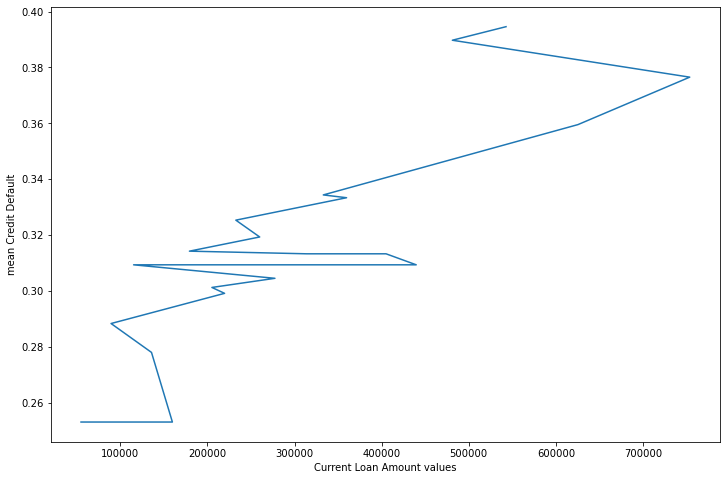

In [1130]:
q2(tr5, 'Current Loan Amount', 'Credit Default')

Итак, имеется следующая картина большинство значений данного параметра лежит в диапазоне 40.000 - 800.000 и в них имеется закономерность, что при возрастании Current Loan Amount целевая переменная стремится к 1 классу.
Однако, имеется 870 обектов, у которых Current Loan Amount = 99.999.999 и все они относятся к 0 классу. Это похоже на какую-то заглушку или вроде того. По-этому предлагаю следующее, добавить булевый признак больше ли Current Loan Amount у объекта чем например 5.000.000, а после заменить зачения 99.999.999 на 0, что бы они не сбивали модель.

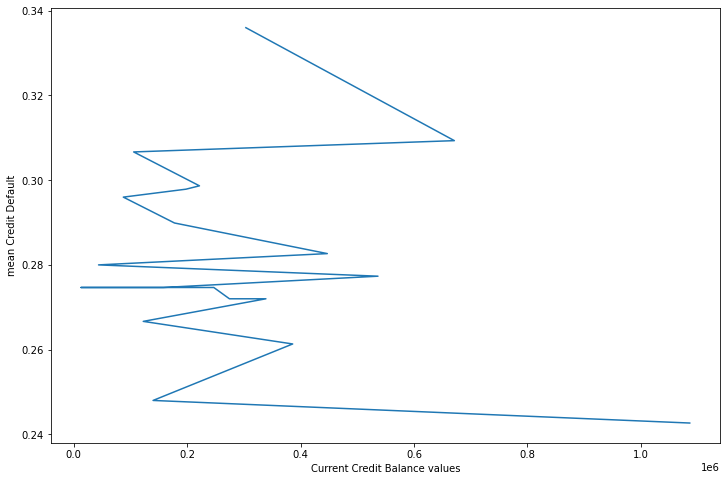

In [1131]:
q2(train, 'Current Credit Balance', 'Credit Default')

Не наблюдается явной закономерности относительно целевого класса.

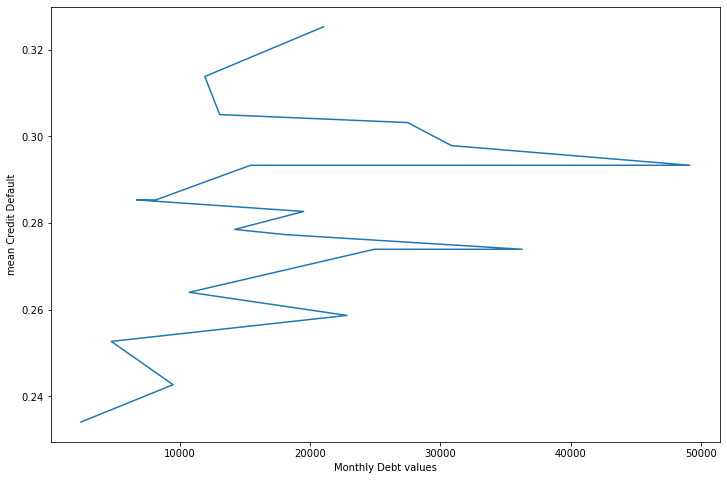

In [1132]:
q2(train, 'Monthly Debt', 'Credit Default') 
#'Current Loan Amount'

Так-же нет особо видимой корреляции с целевой переменной. 

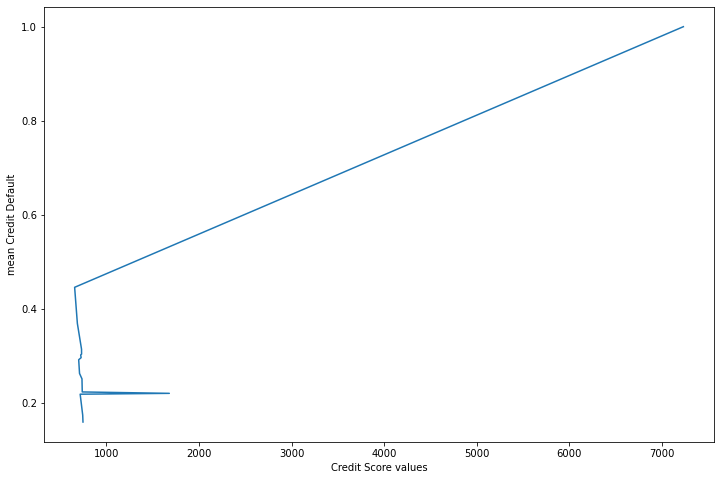

In [1133]:
q2(tr1, 'Credit Score', 'Credit Default')

Похоже здесь ситуация схожая с Current Loan Amount, основная масса обектов лежим в неком диапазоне, но имеется некоторый существенный процент обектов, значения Credit Score которых отличается на порядок от основной массы.

In [1134]:
er1 = train.loc[train['Credit Score'] < 1000]
print(er1['Credit Score'].count())
print(max(er1['Credit Score']))
print(min(er1['Credit Score']))
print(er1['Credit Default'].mean())

7100
751.0
632.99
0.2412676056338028


In [1135]:
er2 = train.loc[train['Credit Score'] > 1000]
print(er2['Credit Score'].count())
print(max(er2['Credit Score']))
print(min(er2['Credit Score']))
print(er2['Credit Default'].mean())

400
7370.0
6060.0
1.0


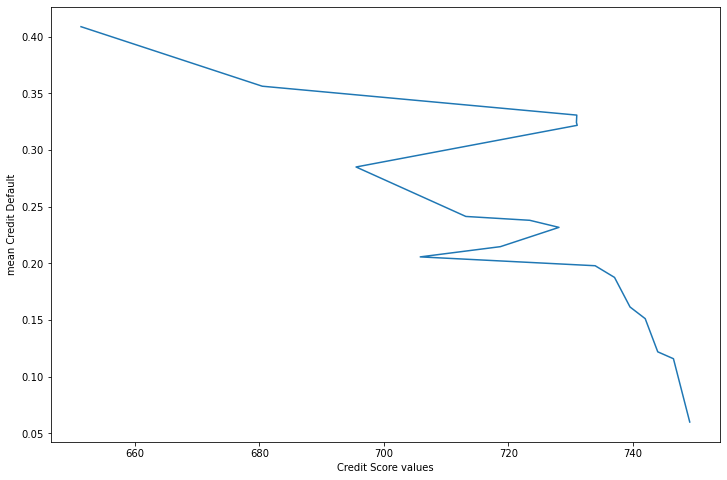

In [1136]:
q2(er1, 'Credit Score', 'Credit Default')

Теория была правдива, основная масса объектов(7100) принимает в данном параметре значения в диапазоне  633-751 и чем выше Credit Score тем больше целевая переменная стремится к 0 классу.
Так же имеется 400 значений в диапазоне 6060-7370, все они относятся к 1 классу. Предлагаю провести аналогичные признаку Current Loan Amount манипуляции. Добавить булевый признак, который будет карактеризовать отношение к этой выборке из 400 значений, например если Credit Score > 1000, после чего все значения, где Credit Score > 1000 сделать равными 500.

Теперь перейдем к анализу нечисловых переменных.

  Home Ownership values  mean Credit Default  count Home Ownership
3         Have Mortgage             0.166667                    12
0         Home Mortgage             0.251856                  3637
2              Own Home             0.296754                   647
1                  Rent             0.313046                  3204


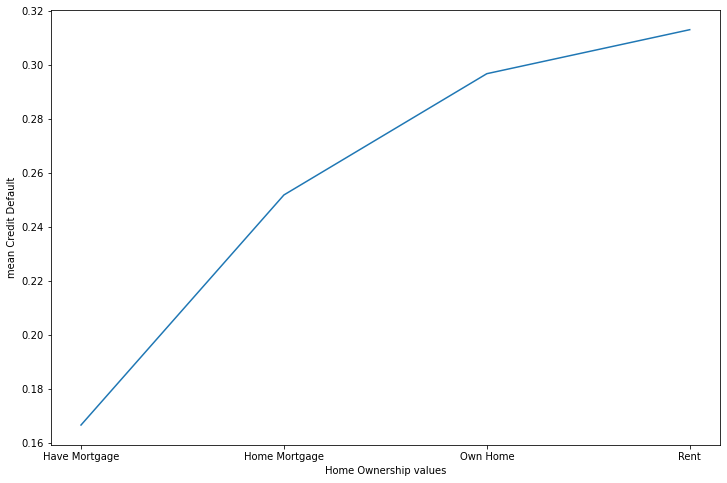

In [1137]:
q1(train,'Home Ownership', 'Credit Default')

В данном признаке видим следующую зависимость целевой переменной:
  0| Home Mortgage < Own Home < Rent |1
  Впринципе это укладывается в логику. Предполагается, что если человеку необходимо оплачивать аренду жилья, то вероятность своевременного погашения кредита несколько ниже. Сделаем из этого признака булевы.
Значение Have Mortgage имеет всего 12 обеъектов из выборки и сильно отличается в разрезе целевой переменной от прочих.

In [1138]:
train.loc[train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

          Purpose values  mean Credit Default  count Purpose
12  educational expenses             0.100000             10
11                moving             0.181818             11
6         major purchase             0.225000             40
4              buy a car             0.250000             96
13              vacation             0.250000              8
2      home improvements             0.262136            412
8              buy house             0.264706             34
10               wedding             0.266667             15
7            take a trip             0.270270             37
0     debt consolidation             0.278264           5944
1                  other             0.296241            665
5          medical bills             0.309859             71
3          business loan             0.426357            129
9         small business             0.538462             26
14      renewable energy             1.000000              2


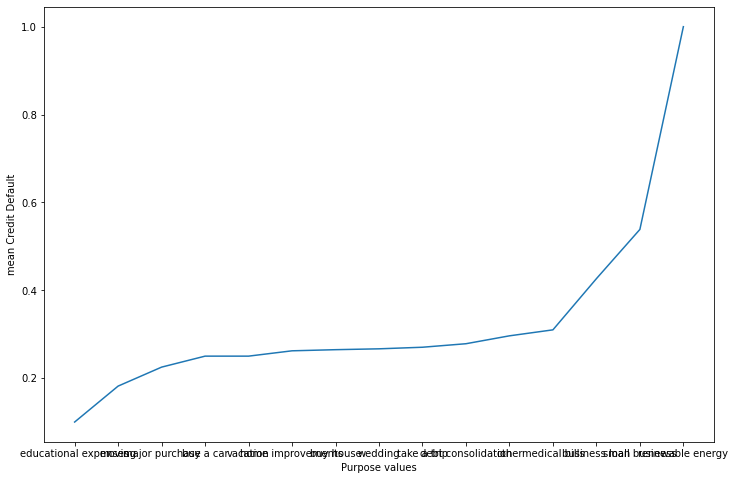

In [1139]:
q1(train,'Purpose','Credit Default')

В данном признаке 93% обектов принимают значения debt consolidation,improvements,other. Остальные значения считаю нерезентабельными, поэтому заменим их на other.

In [1140]:
x = ['educational expenses','moving','major purchase','buy a car','vacation','buy house','wedding','take a trip','medical bills','business loan','small business','renewable energy']
for i in x:
    train.loc[train['Purpose'] == i, 'Purpose'] = 'other'

       Purpose values  mean Credit Default  count Purpose
2   home improvements             0.262136            412
0  debt consolidation             0.278264           5944
1               other             0.306818           1144


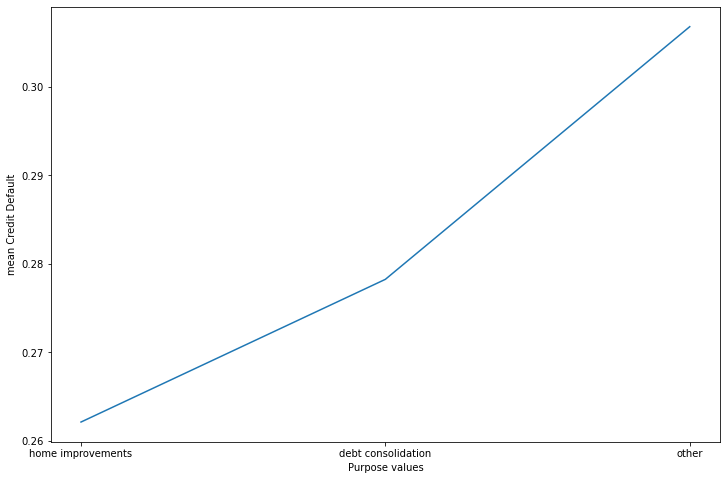

In [1141]:
q1(train,'Purpose','Credit Default')

Впринципе удалось сохранить тенденцию распределения целевой переменной. Теперь этот признак готов к превращению в булевы. 

  Term values  mean Credit Default  count Term
0  Short Term             0.233441        5556
1   Long Term             0.419753        1944


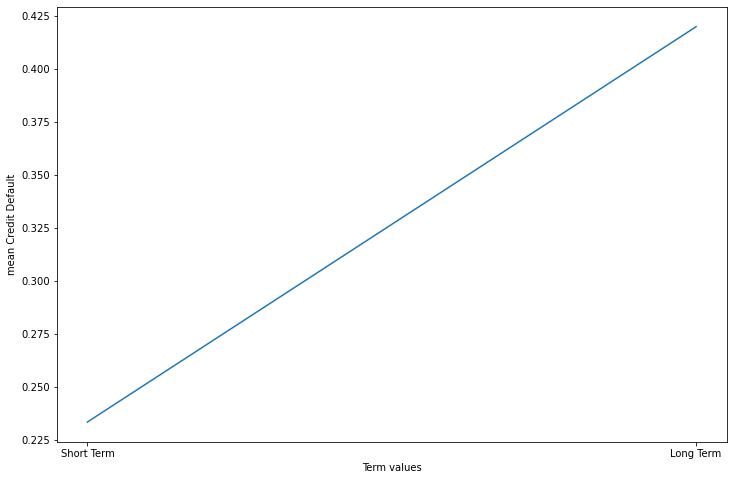

In [1142]:
q1(train,'Term','Credit Default')

Очень хороший булевый признак, зачения целевой переменной для Short Term и Long Term явно сильно различаются.

   Years in current job values  mean Credit Default  \
10                     9 years             0.250965   
9                      8 years             0.271386   
1                      2 years             0.273759   
2                      3 years             0.274194   
0                    10+ years             0.276039   
6                      4 years             0.279318   
8                      7 years             0.280303   
4                      5 years             0.281008   
5                       1 year             0.281746   
3                     < 1 year             0.282416   
7                      6 years             0.291080   

    count Years in current job  
10                         259  
9                          339  
1                          705  
2                          620  
0                         2333  
6                          469  
8                          396  
4                          516  
5                          504  
3        

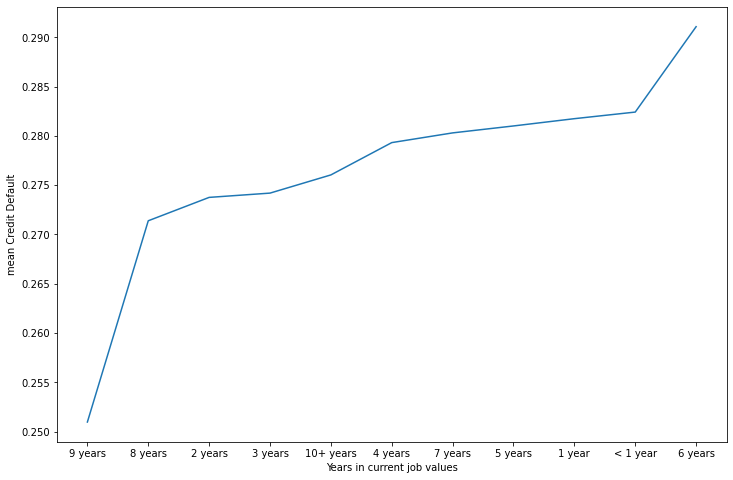

In [1143]:
q1(train,'Years in current job','Credit Default')

Данный признак означает количество лет на текущем месте работы, логично было бы предположить что чем больше темвыше шанс оплаты кредита вовремя, однако мы подобного ненаблюдаем, кроме того влияние данного признака на переменную видимо вообще отсуствует. Возможно он будет полезен в плане взаимодействия на другие переменные.

In [1144]:
#x = train['Years in current job'].value_counts().index
#k = 0
#for i in x:
#    c = x[k][0]
#    c = str(c)
#    train.loc[train['Years in current job'] == 'i', 'Years in current job'] = x[k][0]
#    k = k + 1
#    print(c)
    
train.loc[train['Years in current job'] == '< 1 year', 'Years in current job'] = '0'
train.loc[train['Years in current job'] == '1 year', 'Years in current job'] = '1'
train.loc[train['Years in current job'] == '2 years', 'Years in current job'] = '2'
train.loc[train['Years in current job'] == '3 years', 'Years in current job'] = '3'
train.loc[train['Years in current job'] == '4 years', 'Years in current job'] = '4'
train.loc[train['Years in current job'] == '5 years', 'Years in current job'] = '5'
train.loc[train['Years in current job'] == '6 years', 'Years in current job'] = '6'
train.loc[train['Years in current job'] == '7 years', 'Years in current job'] = '7'
train.loc[train['Years in current job'] == '8 years', 'Years in current job'] = '8'
train.loc[train['Years in current job'] == '9 years', 'Years in current job'] = '9'
train.loc[train['Years in current job'] == '10+ years', 'Years in current job'] = '15'
train['Years in current job'] = pd.to_numeric(train['Years in current job'])
train['Years in current job'] = train['Years in current job'].fillna(train['Years in current job'].median())

#df[s4] = df[s4].fillna(df[s4].mode())
#train['Years in current job'].value_counts()
#train.info()


In [1145]:
scaler = StandardScaler()

In [1146]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import featuretools as ft
import featuretools.variable_types as vtypes

from sklearn.svm import SVC
SVC()

import warnings
warnings.filterwarnings('ignore')

In [1147]:
train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.310095e+06,7.442133,0.017867,11.100667,18.284077,6.348151e+05,0.157333,33.222800,0.110133,1.187331e+07,2.812933e+05,18184.129333,1063.504033,0.281733
std,6.558354e+05,5.533034,0.132476,4.766154,6.870046,5.659747e+05,0.415134,14.587847,0.313077,3.192607e+07,2.553940e+05,11277.579985,1435.765762,0.449874
min,3.644662e+05,0.000000,0.000000,3.000000,6.500000,1.726978e+04,0.000000,3.000000,0.000000,4.318556e+04,1.443810e+03,1320.950000,632.990000,0.000000
25%,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.499974e+06,15.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,32.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,4.225967e+06,15.000000,1.000000,27.000000,40.401000,3.568459e+06,2.000000,79.000000,1.000000,1.000000e+08,1.483079e+06,58113.130000,7370.000000,1.000000


In [1148]:
train.groupby('Home Ownership', as_index=False).median()[['Annual Income','Home Ownership', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount','Credit Score','Monthly Debt']]

,Annual Income,Home Ownership,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Credit Score,Monthly Debt
0,1168386.0,Home Mortgage,563618.0,32.0,344388.0,731.0,18662.0
1,1147448.0,Own Home,472802.0,32.0,268180.0,731.0,14301.0
2,1168386.0,Rent,400345.0,32.0,260491.0,731.0,13869.0


In [1149]:
train.groupby('Purpose', as_index=False).median()[['Annual Income','Purpose', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount','Credit Score','Monthly Debt']]

,Annual Income,Purpose,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Credit Score,Monthly Debt
0,1168386.0,debt consolidation,496771.0,32.0,324104.0,731.0,16595.5
1,1168386.0,home improvements,467577.0,32.0,324027.0,731.0,15895.0
2,1168386.0,other,393107.0,32.0,215600.0,731.0,12503.0


In [1150]:
train.groupby('Term', as_index=False).median()[['Annual Income','Current Credit Balance','Term', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount','Credit Score','Monthly Debt']]

,Annual Income,Current Credit Balance,Term,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Credit Score,Monthly Debt
0,1168386.0,276108.0,Long Term,575531.0,32.0,437063.0,721.0,19175.5
1,1168386.0,190000.0,Short Term,443630.0,32.0,250118.0,731.0,15004.0


In [1151]:
train.groupby('Number of Open Accounts', as_index=False).median()[['Annual Income','Number of Open Accounts', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount','Credit Score','Monthly Debt']]
#train.loc[train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage' 

,Annual Income,Number of Open Accounts,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Credit Score,Monthly Debt
0,935560.0,3.0,135498.0,32.0,141328.0,731.0,5255.0
1,1023824.5,4.0,206360.0,32.0,200057.0,731.0,6880.5
2,1078972.0,5.0,248974.0,32.0,218064.0,731.0,8598.0
3,1168386.0,6.0,294261.0,32.0,257785.0,731.0,10342.0
4,1168386.0,7.0,326392.0,32.0,266024.0,731.0,12860.0
5,1168386.0,8.0,388960.0,32.0,270028.0,731.0,13885.5
6,1168386.0,9.0,425645.0,32.0,288607.0,731.0,14837.5
7,1168386.0,10.0,457204.0,32.0,323840.0,731.0,16508.0
8,1168386.0,11.0,524392.0,32.0,323851.0,731.0,17735.5
9,1168386.0,12.0,539473.0,32.0,318901.0,731.0,18686.5


In [1152]:

df_cat1 = train.groupby('Home Ownership', as_index=False).median()[['Home Ownership', 'Maximum Open Credit','Current Loan Amount','Monthly Debt','Current Credit Balance']].rename(columns={
    'Maximum Open Credit':'1Maximum Open Credit_sfsfancode_marriage1',
    'Current Loan Amount':'1Currggent Loan Amount_dasdaencode_marriage1',
    'Current Credit Balance':'1Current Credit Balancegfddf_marriage1',
    'Monthly Debt':'1Monthly Debt_encodeasdafs_marriage1'})
df_cat1 = pd.DataFrame(df_cat1)


df_cat2 = train.groupby('Purpose', as_index=False).median()[['Purpose','Current Credit Balance', 'Maximum Open Credit','Current Loan Amount','Monthly Debt']].rename(columns={
    'Maximum Open Credit':'2Maximum Open Credit_encodedfdfsd_marriage2',
    'Current Loan Amount':'2Current Loan Amount_encodedfvvv_marriage2',
    'Current Credit Balance':'2Current Credit Balancesadfgb_marriage2',
    'Monthly Debt':'2Monthly Debt_encodsaggde_marriage2'})
df_cat2 = pd.DataFrame(df_cat2)


df_cat3 = train.groupby('Term', as_index=False).median()[['Term', 'Maximum Open Credit','Current Credit Balance','Current Loan Amount','Monthly Debt']].rename(columns={
    'Maximum Open Credit':'3Maximum Open Credit_encodegdfcad_marriage3',
    'Current Loan Amount':'3Current Loan Amount_encodehgjdewvc_marriage3',
    'Current Credit Balance':'3Current Credit Balance_ggsdfsmarriage3',
    'Monthly Debt':'Monthly Debt_encode_marriage3'})
df_cat3 = pd.DataFrame(df_cat3)

df_cat4 = train.groupby('Number of Open Accounts', as_index=False).median()[['Number of Open Accounts','Current Credit Balance','Annual Income', 'Maximum Open Credit','Current Loan Amount','Monthly Debt']].rename(columns={
    'Maximum Open Credit':'4Maximum Open Credit_encodegdfssg_marriage4',
    'Current Loan Amount':'4Current Loan Amount_encodehhsd_marriage4',
    'Current Credit Balance':'4Current Credit Balancefdhsdhd_marriage4',
    'Monthly Debt':'4Monthly Debt_encode_marrgdsfdiage4',
    'Annual Income':'4Annual Income_encode_marriasfdgsdgge1'})
df_cat4 = pd.DataFrame(df_cat4)

df_cat5 = train.groupby('Annual Income', as_index=False).median()[['Annual Income', 'Maximum Open Credit','Current Credit Balance','Current Loan Amount','Monthly Debt','Months since last delinquent']].rename(columns={
    'Maximum Open Credit':'5Maximum Open Credit_encodewtrwqe_marriage5',
    'Current Loan Amount':'5Current Loan Amount_encodfsgde_marriage5',
    'Monthly Debt':'Monthly 5Debt_encode_marriadsfgdfsge5',
    'Current Credit Balance':'5Current Credit Balance_marrsdafiage5',
    'Months since last delinquent':'1Months since last delingfddfgfquent_encode_marriage1',})
df_cat5 = pd.DataFrame(df_cat5)

train = train.merge(df_cat1, on='Home Ownership', how='left')
train = train.merge(df_cat2, on='Purpose', how='left')
train = train.merge(df_cat3, on='Term', how='left')
train = train.merge(df_cat4, on='Number of Open Accounts', how='left')
train = train.merge(df_cat5, on='Annual Income', how='left')

In [1153]:
#qwer = train
#y = qwer['Credit Default']
#qwer = pd.get_dummies(qwer)
#qwer = qwer.drop(columns='Credit Default')
#X =  qwer[qwer.select_dtypes(exclude='object').columns] = scaler.fit_transform(qwer[qwer.select_dtypes(exclude='object').columns])

qwer1 = train.copy()
qwer1.loc[qwer1['Current Loan Amount'] > 5000000, 'Current Loan Amount_big'] = '1'
qwer1['Current Loan Amount_big'] = qwer1['Current Loan Amount_big'].fillna('0')
qwer1.loc[qwer1['Current Loan Amount'] > 5000000, 'Current Loan Amount'] = 0

qwer2 = qwer1.copy()
qwer2.loc[qwer2['Credit Score'] > 1000, 'Credit Score_big'] = '1'
qwer2['Credit Score_big'] = qwer2['Credit Score_big'].fillna('0')
qwer2.loc[qwer2['Credit Score'] > 1000, 'Credit Score'] = 400

qwer3 = qwer2.copy()
qwer3.loc[qwer3['Bankruptcies'] > 1000, 'Bankruptcies_yes'] = '1'
qwer3['Bankruptcies_yes'] = qwer3['Bankruptcies_yes'].fillna('0')

qwer4 = qwer3.copy()
qwer4.loc[qwer4['Tax Liens'] > 0, 'Tax Liens_yes'] = '1'
qwer4['Tax Liens_yes'] = qwer4['Tax Liens_yes'].fillna('0')

qwer5 = qwer4.copy()
qwer5.loc[qwer5['Number of Credit Problems'] > 0, 'Number of Credit Problems_yes'] = '1'
qwer5['Number of Credit Problems_yes'] = qwer5['Number of Credit Problems_yes'].fillna('0')

qwer6 = qwer5.copy()
qwer6['Annual Income_Current Loan Amount'] =  qwer6['Current Loan Amount'] / qwer6['Annual Income']
qwer6['Annual Income_Current Loan Amount_AVG'] = qwer6['Annual Income_Current Loan Amount'] / np.mean(qwer6['Annual Income_Current Loan Amount'])
qwer6['Annual Income_Current_AVG'] = qwer6['Annual Income'] / np.mean(qwer6['Annual Income'])
qwer6['Maximum Open Credit_AVG']  = qwer6['Maximum Open Credit'] / np.mean(qwer6['Maximum Open Credit'])
qwer6['Months since last delinquent_AVG'] = qwer6['Months since last delinquent'] / np.mean(qwer6['Months since last delinquent'])
qwer6['Credit Score_AVG'] = qwer6['Credit Score'] / np.mean(qwer6['Credit Score'])
qwer6['Maximum Open Credit_Annual Income'] = qwer6['Maximum Open Credit'] / qwer6['Annual Income']
qwer6['Maximum Open Credit_Current Loan Amount'] = qwer6['Current Loan Amount'] / qwer6['Maximum Open Credit']
qwer6['Current Credit Balance_Current Loan Amount'] = qwer6['Current Loan Amount'] / qwer6['Current Credit Balance']
qwer6['Credit Score_Months since last delinquent'] = qwer6['Credit Score'] * qwer6['Months since last delinquent']
qwer6['Current Loan Amount_Monthly Debt'] = qwer6['Current Loan Amount'] / qwer6['Monthly Debt']
qwer6['Monthly Debt_s'] = qwer6['Current Loan Amount_Monthly Debt'] / np.mean(qwer6['Current Loan Amount_Monthly Debt'])
qwer6['Current Loan Amount_Months since last delinquent'] = qwer6['Current Loan Amount'] / qwer6['Months since last delinquent']
#qwer6['Home Ownership_Annual Income_Current_AVG'] = qwer6['Annual Income'].loc['Home Ownership'==]
#qwer6['Home Ownership_Annual Income_Current_AVG'] = 

#qwer7 = qwer5.copy()
#qwer7= qwer7.drop(columns=['Credit Score','Current Credit Balance','Years of Credit History','Tax Liens','Number of Open Accounts','Years in current job','Bankruptcies'])

qwer8 = qwer6.copy()
y = qwer8['Credit Default'].copy()
qwer8 = pd.get_dummies(qwer8)
qwer8 = qwer8.drop(columns='Credit Default')

qwer8[qwer8.select_dtypes(exclude='object').columns] = scaler.fit_transform(qwer8[qwer8.select_dtypes(exclude='object').columns])

X = qwer8.copy()
#train_norm.head(10)
#train_norm.info()

In [1154]:
X

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Term_Short Term,Current Loan Amount_big_0,Current Loan Amount_big_1,Credit Score_big_0,Credit Score_big_1,Bankruptcies_yes_0,Tax Liens_yes_0,Tax Liens_yes_1,Number of Credit Problems_yes_0,Number of Credit Problems_yes_1
0,-1.262609,1.366044,-0.134877,-0.021123,1.166871,0.090372,2.030004,-0.083829,2.842517,-1.382150,...,0.591517,-2.760560,2.760560,0.237356,-0.237356,0.0,0.134877,-0.134877,-2.504893,2.504893
1,-0.433992,1.366044,-0.134877,0.818184,-0.434389,0.966388,-0.379020,-0.083829,-0.351801,-0.042179,...,-1.690569,0.362245,-0.362245,0.237356,-0.237356,0.0,0.134877,-0.134877,0.399219,-0.399219
2,-0.851922,0.100831,-0.134877,-0.021123,2.433323,0.967632,-0.379020,-0.083829,-0.351801,-1.382150,...,0.591517,-2.760560,2.760560,0.237356,-0.237356,0.0,0.134877,-0.134877,0.399219,-0.399219
3,-0.770103,-0.260658,-0.134877,-0.650603,0.613708,-0.861253,2.030004,-0.083829,2.842517,-0.768238,...,0.591517,0.362245,-0.362245,0.237356,-0.237356,0.0,0.134877,-0.134877,-2.504893,2.504893
4,-0.814026,0.100831,-0.134877,0.398531,-0.681857,-0.439941,2.030004,-0.083829,-0.351801,-0.745764,...,0.591517,0.362245,-0.362245,0.237356,-0.237356,0.0,0.134877,-0.134877,-2.504893,2.504893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-1.384438,-1.345126,-0.134877,-1.699737,-1.424260,-0.931109,-0.379020,-0.083829,-0.351801,-0.727963,...,0.591517,0.362245,-0.362245,0.237356,-0.237356,0.0,0.134877,-0.134877,0.399219,-0.399219
7496,0.341402,-1.164382,-0.134877,-0.230949,1.195985,0.090994,-0.379020,0.670274,-0.351801,0.863447,...,-1.690569,0.362245,-0.362245,-4.213075,4.213075,0.0,0.134877,-0.134877,0.399219,-0.399219
7497,0.867371,-0.260658,-0.134877,0.188704,2.011172,2.021612,-0.379020,-0.083829,-0.351801,-1.382150,...,0.591517,-2.760560,2.760560,0.237356,-0.237356,0.0,0.134877,-0.134877,0.399219,-0.399219
7498,-0.216089,-0.260658,-0.134877,2.077145,1.195985,0.894861,-0.379020,-0.083829,-0.351801,1.729355,...,0.591517,0.362245,-0.362245,0.237356,-0.237356,0.0,0.134877,-0.134877,0.399219,-0.399219


In [1155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.25,random_state=21,stratify=y)

In [1156]:
model_lr = LogisticRegression()

model_knn = KNeighborsClassifier()

model_tree = DecisionTreeClassifier(random_state=21, class_weight={1:0, 1:3}, max_depth=5)

model_SVC = SVC(kernel='rbf')

model_xgb = xgb.XGBClassifier(random_state=21, n_estimators=100)

model_lgbm = lgbm.LGBMClassifier(random_state=21, class_weight={1:0, 1:3},n_estimators=100)

#c = [model_lr,model_knn,model_tree,model_SVC,model_xgb,model_lgbm]

#for i in c:
    #f.append(i)


#f.append([model_lr,model_knn,model_tree,model_SVC,model_xgb,model_lgbm])

In [1157]:
model_lr.fit(X_train, y_train)

model_knn.fit(X_train, y_train)

model_tree.fit(X_train, y_train)

model_SVC.fit(X_train, y_train)

model_xgb.fit(X_train, y_train)

model_lgbm.fit(X_train, y_train)

[20:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


LGBMClassifier(class_weight={1: 3}, random_state=21)

In [1158]:
pred_train1 = model_lr.predict(X_train)
pred_test1 = model_lr.predict(X_test)

pred_train2 = model_knn.predict(X_train)
pred_test2 = model_knn.predict(X_test)

pred_train3 = model_tree.predict(X_train)
pred_test3 = model_tree.predict(X_test)

pred_train4 = model_SVC.predict(X_train)
pred_test4 = model_SVC.predict(X_test)

pred_train5 = model_xgb.predict(X_train)
pred_test5 = model_xgb.predict(X_test)

pred_train6 = model_lgbm.predict(X_train)
pred_test6 = model_lgbm.predict(X_test)

In [1159]:
#f1_score(y_train, pred_train, average='micro')
print('*********************************model_lr******************************************')
print('train',classification_report(y_train, pred_train1))
print('test',classification_report(y_test, pred_test1))
print('*********************************model_knn******************************************')
print('train',classification_report(y_train, pred_train2))
print('test',classification_report(y_test, pred_test2))
print('*********************************model_tree******************************************')
print('train',classification_report(y_train, pred_train3))
print('test',classification_report(y_test, pred_test3))
print('*********************************model_SVC******************************************')
print('train',classification_report(y_train, pred_train4))
print('test',classification_report(y_test, pred_test4))
print('*********************************model_xgb******************************************')
print('train',classification_report(y_train, pred_train5))
print('test',classification_report(y_test, pred_test5))
print('*********************************model_lgbm******************************************')
print('train',classification_report(y_train, pred_train6))
print('test',classification_report(y_test, pred_test6))

*********************************model_lr******************************************
train               precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      4040
         1.0       0.79      0.30      0.44      1585

    accuracy                           0.78      5625
   macro avg       0.79      0.64      0.65      5625
weighted avg       0.78      0.78      0.74      5625

test               precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      1347
         1.0       0.79      0.28      0.42       528

    accuracy                           0.78      1875
   macro avg       0.78      0.63      0.64      1875
weighted avg       0.78      0.78      0.74      1875

*********************************model_knn******************************************
train               precision    recall  f1-score   support

         0.0       0.82      0.94      0.88      4040
         1.0       0.76      0.48      0.59      15

In [1160]:
pred_train3 = model_tree.predict(X_train)
pred_test3 = model_tree.predict(X_test)

In [1161]:
test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [1162]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [1163]:
s1(test)
test

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.00,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,361481.27,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.00,3 years,0.0,10.0,13.7,204600.0,0.0,30.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.00,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.00,6 years,0.0,11.0,23.6,1207272.0,0.0,30.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.00,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.00,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.00,2 years,0.0,27.0,12.8,1706430.0,0.0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.00,10+ years,0.0,14.0,28.8,945780.0,0.0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [1164]:
for o in test.select_dtypes(include='object').columns:
    print(test[o].value_counts(), '\n')

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64 

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64 

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64 

Short Term    1861
Long Term      639
Name: Term, dtype: int64 



In [1165]:
test.loc[test['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [1166]:
x = ['educational expenses','moving','major purchase','buy a car','vacation','buy house','wedding','take a trip','medical bills','business loan','small business','renewable energy']

for i in x:
    test.loc[test['Purpose'] == i, 'Purpose'] = 'other'

In [1167]:
test.loc[test['Years in current job'] == '< 1 year', 'Years in current job'] = '0'
test.loc[test['Years in current job'] == '1 year', 'Years in current job'] = '1'
test.loc[test['Years in current job'] == '2 years', 'Years in current job'] = '2'
test.loc[test['Years in current job'] == '3 years', 'Years in current job'] = '3'
test.loc[test['Years in current job'] == '4 years', 'Years in current job'] = '4'
test.loc[test['Years in current job'] == '5 years', 'Years in current job'] = '5'
test.loc[test['Years in current job'] == '6 years', 'Years in current job'] = '6'
test.loc[test['Years in current job'] == '7 years', 'Years in current job'] = '7'
test.loc[test['Years in current job'] == '8 years', 'Years in current job'] = '8'
test.loc[test['Years in current job'] == '9 years', 'Years in current job'] = '9'
test.loc[test['Years in current job'] == '10+ years', 'Years in current job'] = '15'
test['Years in current job'] = pd.to_numeric(test['Years in current job'])
test['Years in current job'] = test['Years in current job'].fillna(test['Years in current job'].median())

In [1168]:
df_cat1 = test.groupby('Home Ownership', as_index=False).median()[['Home Ownership', 'Maximum Open Credit','Current Loan Amount','Monthly Debt','Current Credit Balance']].rename(columns={
    'Maximum Open Credit':'1Maximum Open Credit_sfsfancode_marriage1',
    'Current Loan Amount':'1Currggent Loan Amount_dasdaencode_marriage1',
    'Current Credit Balance':'1Current Credit Balancegfddf_marriage1',
    'Monthly Debt':'1Monthly Debt_encodeasdafs_marriage1'})
df_cat1 = pd.DataFrame(df_cat1)


df_cat2 = test.groupby('Purpose', as_index=False).median()[['Purpose','Current Credit Balance', 'Maximum Open Credit','Current Loan Amount','Monthly Debt']].rename(columns={
    'Maximum Open Credit':'2Maximum Open Credit_encodedfdfsd_marriage2',
    'Current Loan Amount':'2Current Loan Amount_encodedfvvv_marriage2',
    'Current Credit Balance':'2Current Credit Balancesadfgb_marriage2',
    'Monthly Debt':'2Monthly Debt_encodsaggde_marriage2'})
df_cat2 = pd.DataFrame(df_cat2)


df_cat3 = test.groupby('Term', as_index=False).median()[['Term', 'Maximum Open Credit','Current Credit Balance','Current Loan Amount','Monthly Debt']].rename(columns={
    'Maximum Open Credit':'3Maximum Open Credit_encodegdfcad_marriage3',
    'Current Loan Amount':'3Current Loan Amount_encodehgjdewvc_marriage3',
    'Current Credit Balance':'3Current Credit Balance_ggsdfsmarriage3',
    'Monthly Debt':'Monthly Debt_encode_marriage3'})
df_cat3 = pd.DataFrame(df_cat3)

df_cat4 = test.groupby('Number of Open Accounts', as_index=False).median()[['Number of Open Accounts','Current Credit Balance','Annual Income', 'Maximum Open Credit','Current Loan Amount','Monthly Debt']].rename(columns={
    'Maximum Open Credit':'4Maximum Open Credit_encodegdfssg_marriage4',
    'Current Loan Amount':'4Current Loan Amount_encodehhsd_marriage4',
    'Current Credit Balance':'4Current Credit Balancefdhsdhd_marriage4',
    'Monthly Debt':'4Monthly Debt_encode_marrgdsfdiage4',
    'Annual Income':'4Annual Income_encode_marriasfdgsdgge1'})
df_cat4 = pd.DataFrame(df_cat4)

df_cat5 = test.groupby('Annual Income', as_index=False).median()[['Annual Income', 'Maximum Open Credit','Current Credit Balance','Current Loan Amount','Monthly Debt','Months since last delinquent']].rename(columns={
    'Maximum Open Credit':'5Maximum Open Credit_encodewtrwqe_marriage5',
    'Current Loan Amount':'5Current Loan Amount_encodfsgde_marriage5',
    'Monthly Debt':'Monthly 5Debt_encode_marriadsfgdfsge5',
    'Current Credit Balance':'5Current Credit Balance_marrsdafiage5',
    'Months since last delinquent':'1Months since last delingfddfgfquent_encode_marriage1',})
df_cat5 = pd.DataFrame(df_cat5)

test = test.merge(df_cat1, on='Home Ownership', how='left')
test = test.merge(df_cat2, on='Purpose', how='left')
test = test.merge(df_cat3, on='Term', how='left')
test = test.merge(df_cat4, on='Number of Open Accounts', how='left')
test = test.merge(df_cat5, on='Annual Income', how='left')

In [1169]:
qwer1 = test.copy()
qwer1.loc[qwer1['Current Loan Amount'] > 5000000, 'Current Loan Amount_big'] = '1'
qwer1['Current Loan Amount_big'] = qwer1['Current Loan Amount_big'].fillna('0')
qwer1.loc[qwer1['Current Loan Amount'] > 5000000, 'Current Loan Amount'] = 0

qwer1.loc[qwer1['Credit Score'] > 1000, 'Credit Score_big'] = '1'
qwer1['Credit Score_big'] = qwer1['Credit Score_big'].fillna('0')
qwer1.loc[qwer1['Credit Score'] > 1000, 'Credit Score'] = 400


qwer1.loc[qwer1['Bankruptcies'] > 1000, 'Bankruptcies_yes'] = '1'
qwer1['Bankruptcies_yes'] = qwer1['Bankruptcies_yes'].fillna('0')


qwer1.loc[qwer1['Tax Liens'] > 0, 'Tax Liens_yes'] = '1'
qwer1['Tax Liens_yes'] = qwer1['Tax Liens_yes'].fillna('0')


qwer1.loc[qwer1['Number of Credit Problems'] > 0, 'Number of Credit Problems_yes'] = '1'
qwer1['Number of Credit Problems_yes'] = qwer1['Number of Credit Problems_yes'].fillna('0')

qwer1['Annual Income_Current Loan Amount'] =  qwer1['Current Loan Amount'] / qwer1['Annual Income']
qwer1['Annual Income_Current Loan Amount_AVG'] = qwer1['Annual Income_Current Loan Amount'] / np.mean(qwer1['Annual Income_Current Loan Amount'])
qwer1['Annual Income_Current_AVG'] = qwer1['Annual Income'] / np.mean(qwer1['Annual Income'])
qwer1['Maximum Open Credit_AVG']  = qwer1['Maximum Open Credit'] / np.mean(qwer1['Maximum Open Credit'])
qwer1['Months since last delinquent_AVG'] = qwer1['Months since last delinquent'] / np.mean(qwer1['Months since last delinquent'])
qwer1['Credit Score_AVG'] = qwer6['Credit Score'] / np.mean(qwer1['Credit Score'])
qwer1['Maximum Open Credit_Annual Income'] = qwer1['Maximum Open Credit'] / qwer1['Annual Income']
qwer1['Maximum Open Credit_Current Loan Amount'] = qwer1['Current Loan Amount'] / qwer1['Maximum Open Credit']
qwer1['Current Credit Balance_Current Loan Amount'] = qwer1['Current Loan Amount'] / qwer1['Current Credit Balance']
qwer1['Credit Score_Months since last delinquent'] = qwer1['Credit Score'] * qwer1['Months since last delinquent']
qwer1['Current Loan Amount_Monthly Debt'] = qwer1['Current Loan Amount'] / qwer1['Monthly Debt']
qwer1['Monthly Debt_s'] = qwer1['Current Loan Amount_Monthly Debt'] / np.mean(qwer1['Current Loan Amount_Monthly Debt'])
qwer1['Current Loan Amount_Months since last delinquent'] = qwer1['Current Loan Amount'] / qwer1['Months since last delinquent']
#qwer6['Home Ownership_Annual Income_Current_AVG'] = qwer6['Annual Income'].loc['Home Ownership'==]
#qwer6['Home Ownership_Annual Income_Current_AVG'] = 

#qwer7 = qwer5.copy()
#qwer7= qwer7.drop(columns=['Credit Score','Current Credit Balance','Years of Credit History','Tax Liens','Number of Open Accounts','Years in current job','Bankruptcies'])


#y = qwer1['Credit Default'].copy()
qwer1 = pd.get_dummies(qwer1)
#qwer1 = qwer1.drop(columns='Credit Default')

qwer1[qwer1.select_dtypes(exclude='object').columns] = scaler.fit_transform(qwer1[qwer1.select_dtypes(exclude='object').columns])

#X = qwer1.copy()

In [1170]:
#d = 1
#for i in X.columns:
#    print(d, i)
#    d += 1

1 Annual Income
2 Years in current job
3 Tax Liens
4 Number of Open Accounts
5 Years of Credit History
6 Maximum Open Credit
7 Number of Credit Problems
8 Months since last delinquent
9 Bankruptcies
10 Current Loan Amount
11 Current Credit Balance
12 Monthly Debt
13 Credit Score
14 1Maximum Open Credit_sfsfancode_marriage1
15 1Currggent Loan Amount_dasdaencode_marriage1
16 1Monthly Debt_encodeasdafs_marriage1
17 1Current Credit Balancegfddf_marriage1
18 2Current Credit Balancesadfgb_marriage2
19 2Maximum Open Credit_encodedfdfsd_marriage2
20 2Current Loan Amount_encodedfvvv_marriage2
21 2Monthly Debt_encodsaggde_marriage2
22 3Maximum Open Credit_encodegdfcad_marriage3
23 3Current Credit Balance_ggsdfsmarriage3
24 3Current Loan Amount_encodehgjdewvc_marriage3
25 Monthly Debt_encode_marriage3
26 4Current Credit Balancefdhsdhd_marriage4
27 4Annual Income_encode_marriasfdgsdgge1
28 4Maximum Open Credit_encodegdfssg_marriage4
29 4Current Loan Amount_encodehhsd_marriage4
30 4Monthly Debt_enc

In [1171]:
#d = 1
#for i in qwer1.columns:
#    print(d, i)
#    d += 1

1 Annual Income
2 Years in current job
3 Tax Liens
4 Number of Open Accounts
5 Years of Credit History
6 Maximum Open Credit
7 Number of Credit Problems
8 Months since last delinquent
9 Bankruptcies
10 Current Loan Amount
11 Current Credit Balance
12 Monthly Debt
13 Credit Score
14 1Maximum Open Credit_sfsfancode_marriage1
15 1Currggent Loan Amount_dasdaencode_marriage1
16 1Monthly Debt_encodeasdafs_marriage1
17 1Current Credit Balancegfddf_marriage1
18 2Current Credit Balancesadfgb_marriage2
19 2Maximum Open Credit_encodedfdfsd_marriage2
20 2Current Loan Amount_encodedfvvv_marriage2
21 2Monthly Debt_encodsaggde_marriage2
22 3Maximum Open Credit_encodegdfcad_marriage3
23 3Current Credit Balance_ggsdfsmarriage3
24 3Current Loan Amount_encodehgjdewvc_marriage3
25 Monthly Debt_encode_marriage3
26 4Current Credit Balancefdhsdhd_marriage4
27 4Annual Income_encode_marriasfdgsdgge1
28 4Maximum Open Credit_encodegdfssg_marriage4
29 4Current Loan Amount_encodehhsd_marriage4
30 4Monthly Debt_enc

In [1176]:
pred_test = model_tree.predict(qwer1)
pred_test = pd.DataFrame(pred_test)

In [1177]:
pred_test.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [332]:
#def sss(df):
#    target = df['Credit Default']
#    df = df.drop(columns=['Credit Default','Years in current job'])
#    f = df.select_dtypes(exclude='object').columns
#    #num_f = df.select_dtypes(exclude='object').columns
#    #cat_f = df.select_dtypes(include='object').columns
#
#    X = []
#   
#    for x1 in f:
#        x2 = df.drop(columns=x1)
#        X.append(x2)
#    
#    for x3 in np.arange(0, len(X)):
#        for x4 in X[x3].columns:
#            if x4 == 'Current Credit Balance':
#                x5 = X[x3].drop(columns='Current Credit Balance')
#                X.append(x5)
#            elif x4 == 'Monthly Debt':
#                x5 = X[x3].drop(columns='Monthly Debt')
#                X.append(x5)
#            elif x4 == 'Years of Credit History':
#                x5 = X[x3].drop(columns='Years of Credit History')
#                X.append(x5)
#                
#    for t in np.arange(0, len(X)):
#        for t1 in X[t].columns:
#            if x4 == 'Monthly Debt':
#                t3 = X[x3].drop(columns='Monthly Debt')
#                X.append(t3)
#        
#    for x6 in np.arange(0, len(X)):
#        for x7 in X[x6].columns:
#            if x7 == 'Credit Score':
#                X[x6].loc[X[x6]['Credit Score'] > 1000, 'Credit Score_big'] = '1'
#                X[x6]['Credit Score_big'] = X[x6]['Credit Score_big'].fillna('0')
#                X[x6].loc[X[x6]['Credit Score'] > 1000, 'Credit Score'] = 400
#                
#            elif x7 == 'Current Loan Amount':
#                X[x6].loc[X[x6]['Current Loan Amount'] > 5000000, 'Current Loan Amount_big'] = '1'
#                X[x6]['Current Loan Amount_big'] = X[x6]['Current Loan Amount_big'].fillna('0')
#                X[x6].loc[X[x6]['Current Loan Amount'] > 5000000, 'Current Loan Amount'] = 0
#                
#    for x8 in np.arange(0, len(X)):
#        for x9 in X[x8].columns:
#            if x9 == 'Current Loan Amount':
#                X[x6].loc[X[x6]['Current Loan Amount'] > 5000000, 'Current Loan Amount_big'] = '1'
#                X[x6]['Current Loan Amount_big'] = X[x6]['Current Loan Amount_big'].fillna('0')
#                X[x6].loc[X[x6]['Current Loan Amount'] > 5000000, 'Current Loan Amount'] = 0
#                
#    for x10 in np.arange(0, len(X)):
#        X[x10] = pd.get_dummies(X[x10])
#       
#    for x11 in np.arange(0, len(X)):
#        x12 = scaler.fit_transform(X[x11][X[x11].select_dtypes(exclude='object').columns])
#        X.append(x12)
#    
#    for x13 in np.arange(0, len(X)):
#        y = target
#        x = X[x10]
#        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
#        X_train.shape, X_test.shape
        
#        model_lr = LogisticRegression()
#        model_lr.fit(X_train, y_train)
        
#        evaluate_preds(model_lr, X_train, X_test, y_train, y_test)
        
#        model_knn = KNeighborsClassifier()
#        model_knn.fit(X_train, y_train)
        
#        evaluate_preds(model_lr, X_train, X_test, y_train, y_test)
        
#        model_tree = DecisionTreeClassifier(random_state=21,class_weight={0:1, 1:3.6},max_depth=4)
#        model_tree.fit(X_train, y_train)
        
#        model_xgb = xgb.XGBClassifier(random_state=21)
#        model_xgb.fit(X_train, y_train)
        
#        evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)
    

In [ ]:
#def q3(df):
   # y = df['Credit Default']
   # df = df.drop(columns='Credit Default')
   # qwer = df
   # qwer = pd.get_dummies(qwer)
   # qwer[qwer.select_dtypes(exclude='object').columns] = scaler.fit_transform(qwer[qwer.select_dtypes(exclude='object').columns])
   # X = qwer
   # X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.25,random_state=21,stratify=y)
    
   # M = [] 
   # model_lr = LogisticRegression()
   # model_knn = KNeighborsClassifier()
   # model_tree = DecisionTreeClassifier(random_state=21, class_weight={1:0, 1:3}, max_depth=5)
   # model_SVC = SVC(kernel='rbf')
   # model_xgb = xgb.XGBClassifier(random_state=21, n_estimators=100)
   # model_lgbm = lgbm.LGBMClassifier(random_state=21, class_weight={1:0, 1:3},n_estimators=100)
   # c = [model_lr,model_knn,model_tree,model_SVC,model_xgb,model_lgbm]
    
   # for i in c:
   #     M.append(i)
    
   # for i in np.arange(0, len(M)):
   #     M[i].fit(X_train, y_train)
        
        
    
    #P_tr = []
    #R_tst = []
    
   #for i in M:
    #    pred_train = i.predict(X_train)
     #   pred_test = i.predict(X_train)
        
     #   P_tr.append(pred_train)
      #  R_tst.append(pred_test)
        
    #e = []
    
    #for i in R_tst:
      #  x = classification_report(y_test, i)
       # x1 = x[148:152]
       # x1 = float(x1)
       # e.append(x1)
   # print(len(M))